# quant-econ Solutions: Continuous State Markov Chains

Solutions for http://quant-econ.net/jl/stationary_densities.html

In [1]:
using QuantEcon
using PyPlot
using KernelDensity
using Distributions

## Exercise 1


Look ahead estimation of a TAR stationary density, where the TAR model is

$$    X_{t+1} = \theta |X_t| + (1 - \theta^2)^{1/2} \xi_{t+1} $$

and $\xi_t \sim N(0,1)$.  Try running at n = 10, 100, 1000, 10000 to get an
idea of the speed of convergence.

/home/chase/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


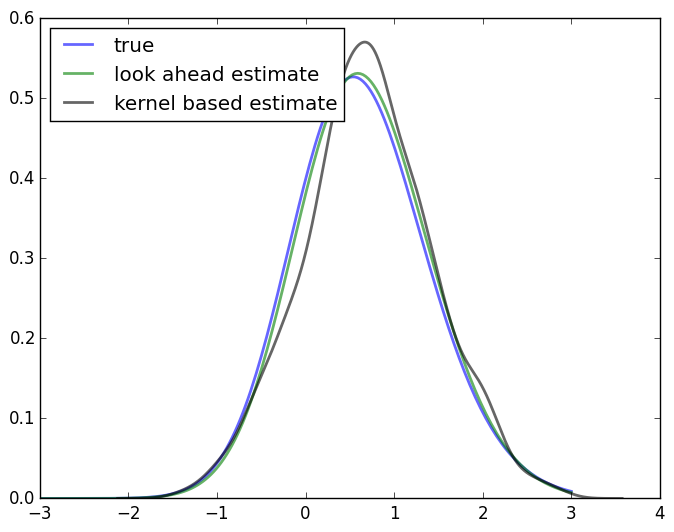

In [2]:
ϕ = Normal(0.0, 1.0)
n = 500
θ = 0.8
d = sqrt(1.0 - θ^2)
δ = θ / d
srand(41)  # reproducible results

# true density of TAR model
ψ_star(y) = 2 .* pdf(ϕ, y) .* cdf(ϕ, δ * y)

# Stochastic kernel for the TAR model.
p(x, y) = pdf(ϕ, (y .- θ .* abs(x)) ./ d) ./ d

Z = rand(ϕ, n)
X = zeros(n)
for t=1:n-1
    X[t+1] = θ * abs(X[t]) + d * Z[t]
end

ψ_est(a) = lae_est(LAE(p, X), a)
k_est = kde(X)

fig, ax = subplots()
ys = linspace(-3, 3, 200)
ax[:plot](ys, ψ_star(ys), "b-", lw=2, alpha=0.6, label="true")
ax[:plot](ys, ψ_est(ys), "g-", lw=2, alpha=0.6, label="look ahead estimate")
ax[:plot](k_est.x, k_est.density, "k-", lw=2, alpha=0.6, label="kernel based estimate")
ax[:legend](loc="upper left")


fig[:show]()

## Exercise 2

Here's one program that does the job.

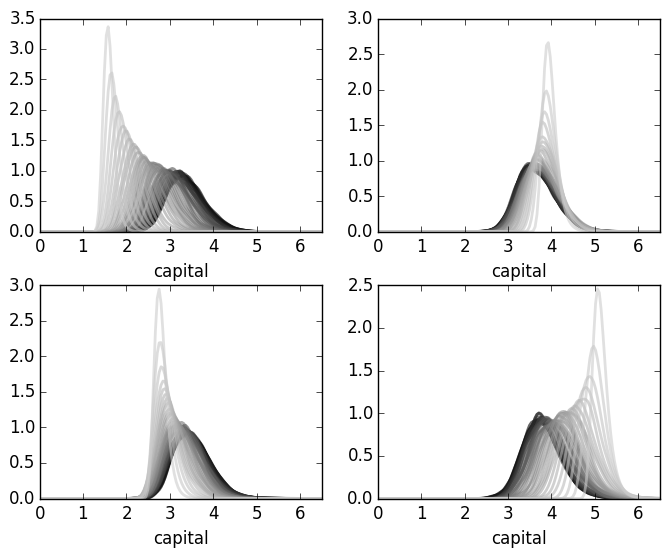

In [3]:
s = 0.2
δ = 0.1
a_σ = 0.4  # A = exp(B) where B ~ N(0, a_sigma)
α = 0.4  # We set f(k) = k**alpha
ψ_0 = Beta(5.0, 5.0)  # Initial distribution
ϕ = LogNormal(0.0, a_σ)
srand(42)  # reproducible results


function p(x, y)
    #=
    Stochastic kernel for the growth model with Cobb-Douglas production.
    Both x and y must be strictly positive.
    =#
    d = s * x.^α

    # scipy silently evaluates the pdf of the lognormal dist at a negative
    # value as zero. It should be undefined and Julia recognizes this.
    pdf_arg = clamp((y .- (1-δ) .* x) ./ d, eps(), Inf)
    return pdf(ϕ, pdf_arg) ./ d
end


n = 1000  # Number of observations at each date t
T = 40  # Compute density of k_t at 1,...,T+1

fig, axes = subplots(2, 2)
axes = axes[:]
xmax = 6.5

for i=1:4
    ax = axes[i]
    ax[:set_xlim](0, xmax)

    # Generate matrix s.t. t-th column is n observations of k_t
    k = Array(Float64, n, T)
    A = rand!(ϕ, Array(Float64, n, T))

    # Draw first column from initial distribution
    # match scale=0.5 and loc=2*i in python version
    k[:, 1] = (rand(ψ_0, n) .+ 2.5i) ./ 2  
    for t=1:T-1
        k[:, t+1] = s*A[:, t] .* k[:, t].^α + (1-δ) .* k[:, t]
    end

    # Generate T instances of LAE using this data, one for each date t
    laes = [LAE(p, k[:, t]) for t=T:-1:1]

    # Plot

    ygrid = linspace(0.01, xmax, 150)
    greys = [string(g) for g in linspace(0.0, 0.8, T)]
    for (psi, g) in zip(laes, greys)
        ax[:plot](ygrid, lae_est(psi, ygrid), color=g, lw=2, alpha=0.6)
    end
    ax[:set_xlabel]("capital")
end

    
fig[:show]()

## Exercise 3

Here's a possible solution.

Note the way we use vectorized code to simulate the $k$ time series for one boxplot all at once.

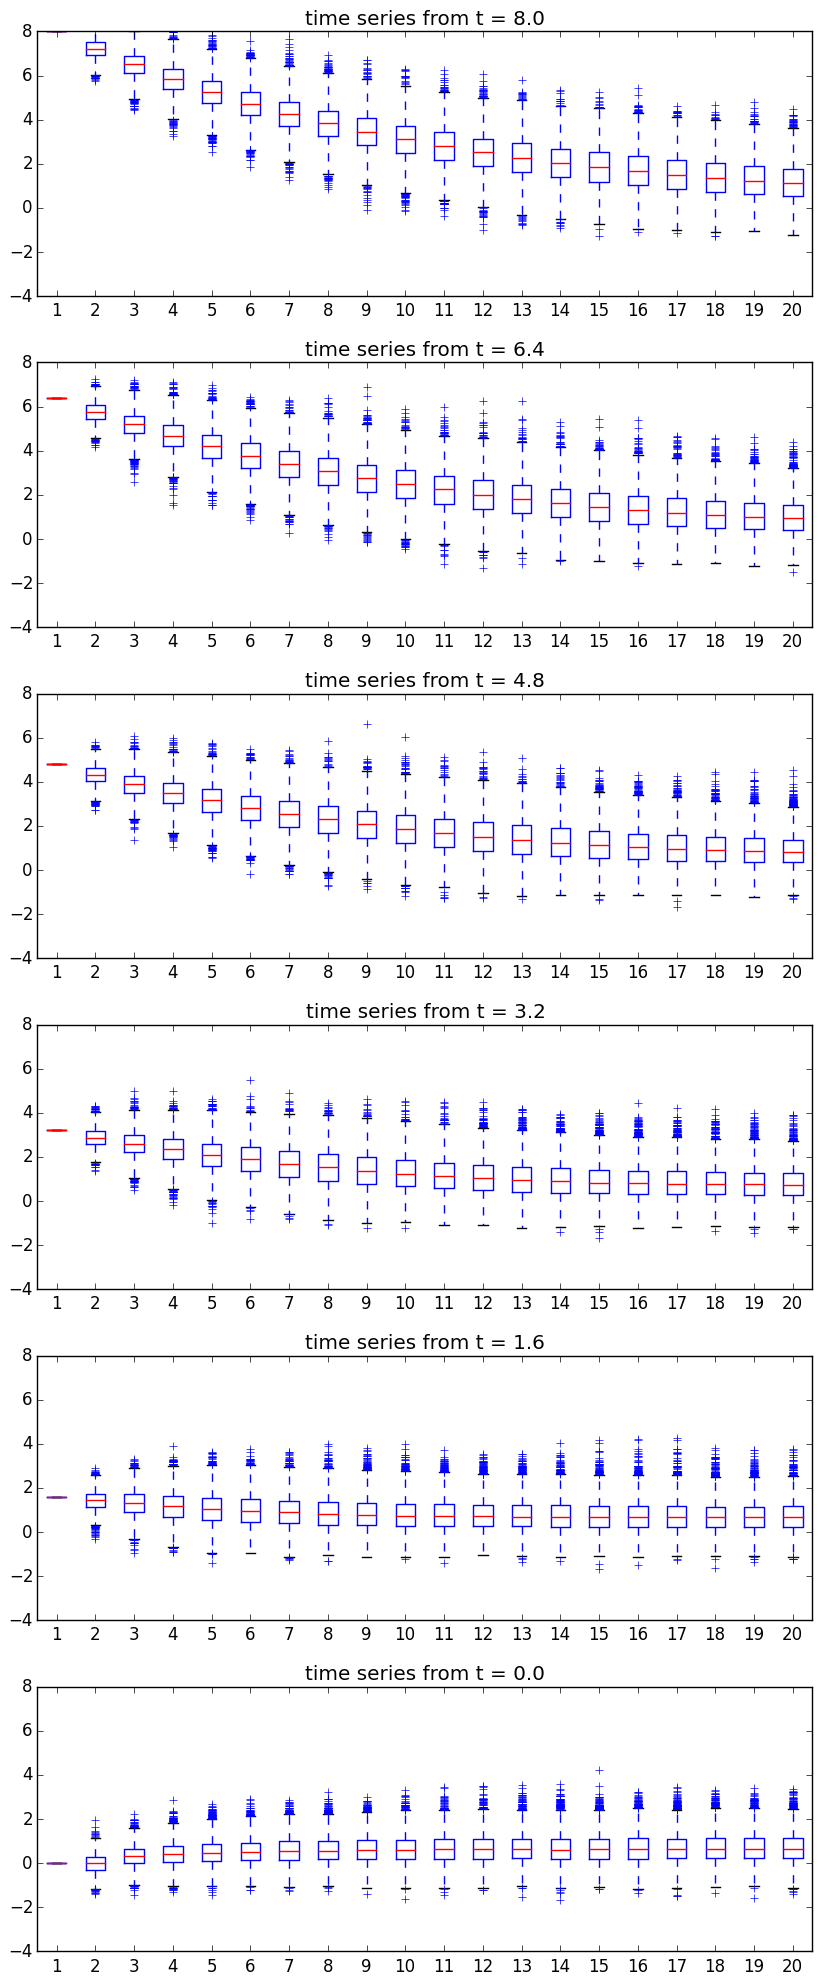

In [4]:
n = 20
k = 5000
J = 6
srand(43)  # reproducible results

θ = 0.9
d = sqrt(1 - θ^2) 
δ = θ / d

fig, axes = subplots(J, 1, figsize=(10, 4*J))
initial_conditions = linspace(8, 0, J)
X = Array(Float64, k, n)

Z = randn(k, n, J)
for j=1:J
    ax = axes[j]
    ax[:set_ylim](-4, 8)
    title = "time series from t = $(initial_conditions[j])"
    ax[:set_title](title)
    
    X[:, 1] = initial_conditions[j]
    for t=2:n
        X[:, t] = θ .* abs(X[:, t-1]) .+ d .* Z[:, t, j]
    end
    ax[:boxplot](X)
end

fig[:show]()